# Which Group of People (given certain features) have the highest yearly income?  
##### Ayse Arslan, Yagmur Mavruk, Zain Farhah
##### https://www.youtube.com/watch?v=ACO81g-__rk PLEASE DO NOT PUBLISH TO BROADER AUDIENCE

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import zscore

**You might get lost from here on. So, we decided to provide you with sections.**  
&emsp;1) [Load Data](#loaddata)  
&emsp;2) [Quick Clean-Up for EDA](#firstcleanup)  
&emsp;3) [Analyze Data and EDA](#eda)  
&emsp;4) [Create Preprocessing Pipeline](#prepro)  
&emsp;5) [Analysis Methods](#modelling)  
&emsp;6) [Ethical Considerations](#ethics)

# 1) Load Data <a name="loaddata"></a>

In [3]:
df = pd.read_csv('adult_reconstruction.csv')
df

,hours-per-week,age,capital-gain,capital-loss,workclass,education,education-num,marital-status,relationship,race,gender,native-country,income,occupation
0,20,40,0,0,Private,Bachelors,13,Married-civ-spouse,Wife,White,Female,United-States,49100,Tech-support
1,40,21,0,0,Private,Some-college,10,Divorced,Own-child,White,Male,United-States,11500,Craft-repair
2,10,17,0,0,Private,11th,7,Never-married,Own-child,White,Male,United-States,2600,Other-service
3,50,51,0,0,Private,HS-grad,9,Married-civ-spouse,Husband,Asian-Pac-Islander,Male,Cambodia,38997,Sales
4,38,28,0,0,Private,Bachelors,13,Never-married,Not-in-family,White,Male,?,41400,Exec-managerial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49526,65,35,0,0,Private,Bachelors,13,Married-civ-spouse,Husband,White,Male,Yugoslavia,85080,Farming-fishing
49527,77,37,3137,0,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Husband,Asian-Pac-Islander,Male,Vietnam,34137,Sales
49528,55,24,0,0,Private,Assoc-voc,11,Never-married,Not-in-family,White,Male,United-States,13016,Sales
49529,40,24,0,0,Private,Some-college,10,Never-married,Not-in-family,White,Female,United-States,15000,Adm-clerical


# 2) Quick Clean-Up for EDA <a name="firstcleanup"></a>

#### Fix missing values

In [4]:
df.isnull().sum()

hours-per-week    0
age               0
capital-gain      0
capital-loss      0
workclass         0
education         0
education-num     0
marital-status    0
relationship      0
race              0
gender            0
native-country    0
income            0
occupation        0
dtype: int64

#### There are some cells with ? in it, so we replace with nans and check the percentage of missing values.

In [5]:
df.isin(['?']).sum()

hours-per-week       0
age                  0
capital-gain         0
capital-loss         0
workclass         2859
education            0
education-num        0
marital-status       0
relationship         0
race                 0
gender               0
native-country     859
income               0
occupation        2869
dtype: int64

In [6]:
df['workclass'] = df['workclass'].replace('?', np.nan)
df['occupation'] = df['occupation'].replace('?', np.nan)
df['native-country'] = df['native-country'].replace('?', np.nan)

perc1 = df['workclass'].isnull().sum()/len(df['workclass'])*100
perc2 = df['occupation'].isnull().sum()/len(df['occupation'])*100
perc3 = df['native-country'].isnull().sum()/len(df['native-country'])*100
print("Missing =", perc1,"% in 'workclass',", perc2,"% in 'occupation',", perc3,"% in 'native-country'")

Missing = 5.7721426985120425 % in 'workclass', 5.792332074862207 % in 'occupation', 1.7342674284791342 % in 'native-country'


In [7]:
df.dropna(how='any', inplace=True)
df.isnull().sum()

hours-per-week    0
age               0
capital-gain      0
capital-loss      0
workclass         0
education         0
education-num     0
marital-status    0
relationship      0
race              0
gender            0
native-country    0
income            0
occupation        0
dtype: int64

#### Now that the missing values have been removed, let's check duplicates

In [8]:
df.duplicated().sum()

208

In [9]:
df = df.drop_duplicates()

### Check for Outliers

[Text(0.5, 1.0, 'Histogram Plot of People Working for Different Hours per Week')]

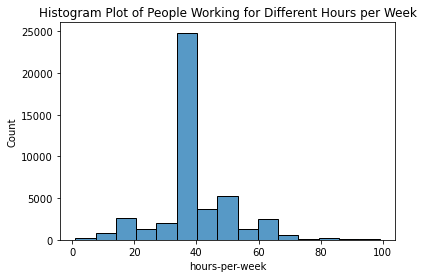

In [10]:
sns.histplot(df['hours-per-week'], bins = 15).set(title = 'Histogram Plot of People Working for Different Hours per Week')

#### Seems like there are some poor exceptional people working more than 80 hours a week. 

99497.03015075377


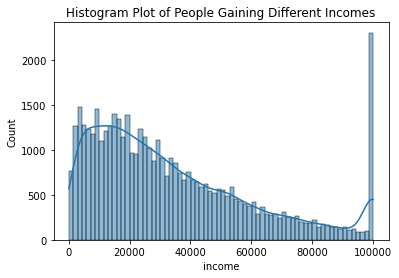

In [11]:
ax = sns.histplot(df['income'], bins=70, kde=True)

kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

ax.set(title = 'Histogram Plot of People Gaining Different Incomes')
##The last bin to remove
print(xs[-2])

#### You can observe that there is _clear_ mode around 99k Dollars. Our data set "only" has the maximum of 99k Dollars. In the real world, there are more people earning more than that per year. So, we don't know how the plot would look for higher income. It is just that our data has not as much instances for <99k Dollars.

[Text(0.5, 1.0, 'Histogram of Capital Gain')]

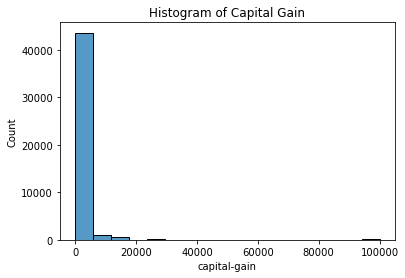

In [12]:
sns.histplot(df['capital-gain']).set(title='Histogram of Capital Gain')

[Text(0.5, 1.0, 'Histogram of Capital Loss')]

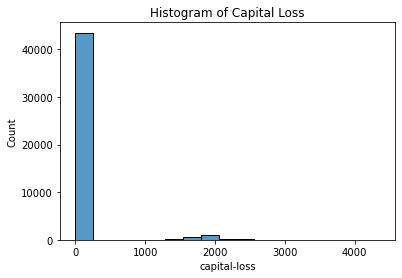

In [13]:
sns.histplot(df['capital-loss']).set(title='Histogram of Capital Loss')

#### Capital gain and capital loss clearly have outliers far away. Most of their entries are 0's, so we do not consider them for our model.

[Text(0.5, 1.0, 'Histogram of Different Ages')]

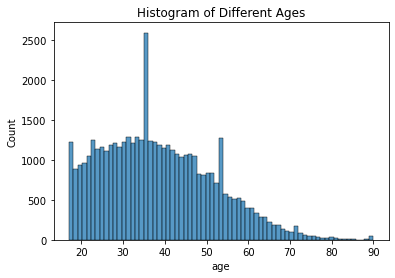

In [14]:
sns.histplot(df['age']).set(title='Histogram of Different Ages')

#### Seems like our data set has a lot of 36-37 years old. As well as 17, 23 and 53. However, we have very few people in our data that are above 73.

We decided to remove the datatpoints, which are greater than the mean by 3 standard deviations, for the hours-per-week.
We also found that the last bin from the histogram of the income (bin 70) does not follow the distribution so we have removed all data points with income greater than 99497.

In [15]:
def remove_outliers_sd(data, variable):
    return data.loc[(np.abs(stats.zscore(data[variable])) < 3)]

def remove_outliers_bound(data, variable, lower=-np.inf, upper=np.inf):
    return data.loc[(data[variable] > lower) & (data[variable] < upper)]

In [16]:
df = remove_outliers_sd(df, 'hours-per-week')
df = remove_outliers_sd(df, 'age')
df = remove_outliers_bound(df, 'income',upper = 99497)

# 3) Analyze Data & EDA <a name="eda"></a>

&emsp;1) [Is there a relationship between sex/race/age and income?](#1)  
&emsp;2) [Is a certain sex/race preferred in a certain occupation given the same education levels?](#2)  
&emsp;3) [Which group of people (considering age, sex, race, marital status) is working the most in terms of hours per week?](#3)  
&emsp;4) [How are the occupation types distributed over the genders?](#4) \

#### Create dummy variables _for the plots only for now_

[Text(0.5, 1.0, 'Histogram of Age')]

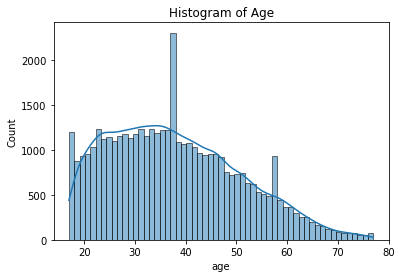

In [17]:
sns.histplot(df['age'], bins=57, kde=True).set(title = 'Histogram of Age')

Since we have ages from 17 to 77, we need to group them so we can plot it with income. We have some modes, so we suggest this grouping:  
Group 1: <= 30  
Group 2: >30 and <45  
Group 3: >= 45

In [18]:
temp = []
for i in df['age']:
    if i <= 30:
        temp.append("Group 1")
    if (i>30) and (i<45):
        temp.append("Group 2")
    if (i>=45):
        temp.append("Group 3")
        
copiedDF = df.copy()
copiedDF['Grouped Ages'] = temp

### 3.1) Is there a relationship between sex/race/age and income? <a name="1"></a>

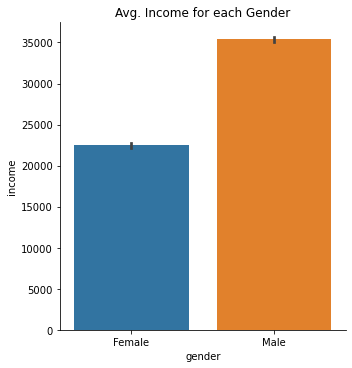

In [19]:
sns.catplot(data=df, kind="bar", x="gender", y="income").set(title='Avg. Income for each Gender')

#### This plot shows the average income of female and male (after outlier removal of course). It is clear to see that male have higher income.

Text(0.5, 1.0, 'Avg. Income for each Race')

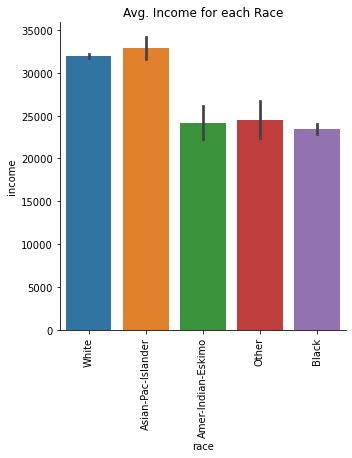

In [20]:
sns.catplot(data=df, kind="bar", x="race", y="income")
plt.xticks(rotation=90)
plt.title('Avg. Income for each Race')

#### Here you can observe that there are two races having higher income on average. The least income has the back race.

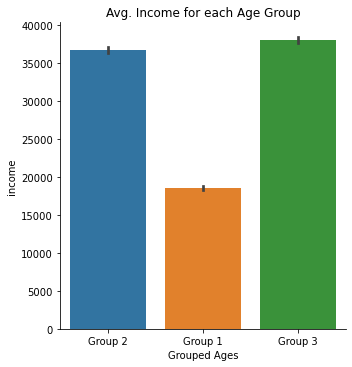

In [21]:
sns.catplot(data=copiedDF, kind="bar", x="Grouped Ages", y="income").set(title='Avg. Income for each Age Group')

#### On average, people below 30 earn the least. However people between 30 and 45 and people between 45 and 77 have approximately the same yearly income on average.

### 3.2) Is a certain sex preferred in a certain occupation given the same education levels? <a name="2"></a>

Text(0.5, 1.0, 'Education Level Counts for the Tech-support Occupation')

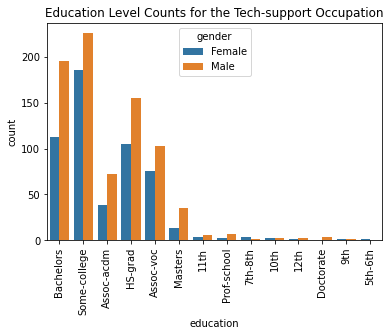

In [22]:
sns.countplot(data=df.loc[df['occupation']=='Tech-support'], x='education', hue='gender')
plt.xticks(rotation=90)
plt.title('Education Level Counts for the Tech-support Occupation')

#### Although the same education level is given, in the tech-support occupation females still earn less. So, same education level, same occupation and still less income for females. In 'Other-service' it alternates, which sex earns more. In 'Adm-clerical' women earn more. In all other occupations though, male always have higher income.

In [23]:
# If you wanna see another occupation
column_values = df[["occupation"]].values.ravel()
unique_values =  pd.unique(column_values)
unique_values

array(['Tech-support', 'Craft-repair', 'Other-service', 'Sales',
       'Exec-managerial', 'Handlers-cleaners', 'Machine-op-inspct',
       'Prof-specialty', 'Adm-clerical', 'Farming-fishing',
       'Transport-moving', 'Priv-house-serv', 'Protective-serv',
       'Armed-Forces'], dtype=object)

### 3.3) Which group of people (considering age, sex, race, marital status) is working the most in terms of hours per week? <a name="3"></a>

###### Age

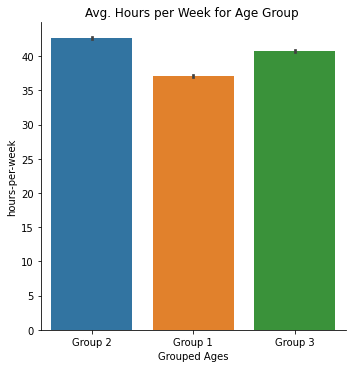

In [24]:
sns.catplot(data=copiedDF, kind="bar", x="Grouped Ages", y="hours-per-week").set(title='Avg. Hours per Week for Age Group ')

#### All age groups approximately work the same amount of hours-per-week on average. The youngest group, (group 1) works slightly less. This perhaps explains or contributes to the fact that group 1 also has less yearly income on average.

###### Gender

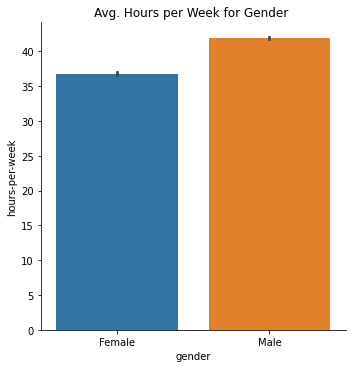

In [25]:
sns.catplot(data=df, kind="bar", x="gender", y="hours-per-week").set(title='Avg. Hours per Week for Gender ')

#### On average, men work slightly more than women given this data set. Perhaps this also contributes to the fact that male earn more than female.

###### Race

Text(0.5, 1.0, 'Avg. Hours per Week for each Race')

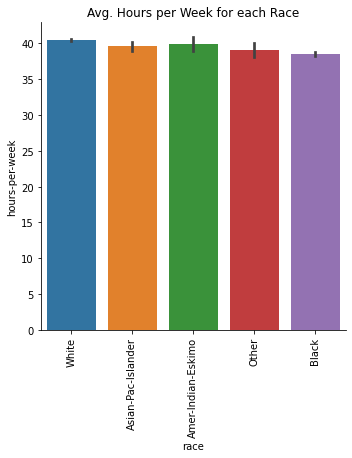

In [26]:
sns.catplot(data=df, kind="bar", x="race", y="hours-per-week")
plt.xticks(rotation=90)
plt.title('Avg. Hours per Week for each Race')

#### This plot clearly shows that all races approximately work the same amount (and still there is a huge gap in the income).

###### Marital Status

Text(0.5, 1.0, 'Avg. Hours per Week for each Marital-Status')

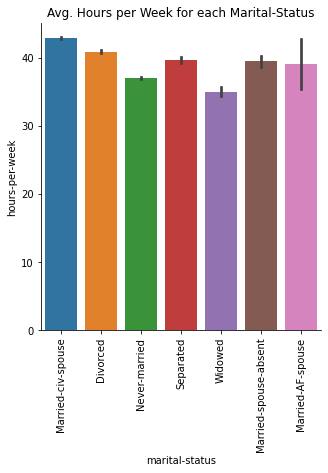

In [27]:
sns.catplot(data=df, kind="bar", x="marital-status", y="hours-per-week")
plt.xticks(rotation=90)
plt.title('Avg. Hours per Week for each Marital-Status')

#### Also here are no extreme cases. The most working are married civilian spouses and the least are widowed people.

### 3.4) How are the occupation types distributed over the genders? <a name="4"></a>

[Text(0.5, 1.0, 'Avg. Number of Gender in Tech Support')]

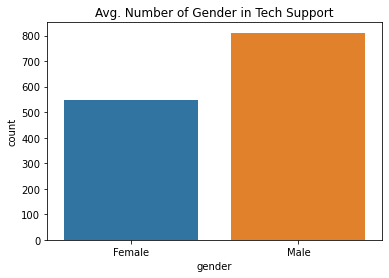

In [28]:
# 'Tech-support', 'Craft-repair', 'Other-service', 'Sales', 'Exec-managerial', 'Handlers-cleaners', 'Machine-op-inspct',
# 'Prof-specialty', 'Adm-clerical', 'Farming-fishing', 'Transport-moving', 'Priv-house-serv', 'Protective-serv', 'Armed-Forces'
sns.countplot(data=copiedDF.loc[df['occupation']=='Tech-support'], x='gender').set(title='Avg. Number of Gender in Tech Support')

#### In other services and administrative clerk, females are more employed. However, in all other occupations in this data set, males are more employed

## Other interesting observations

Text(0.5, 1.0, 'Bar Plot of Gender vs Income for Each Occupation')

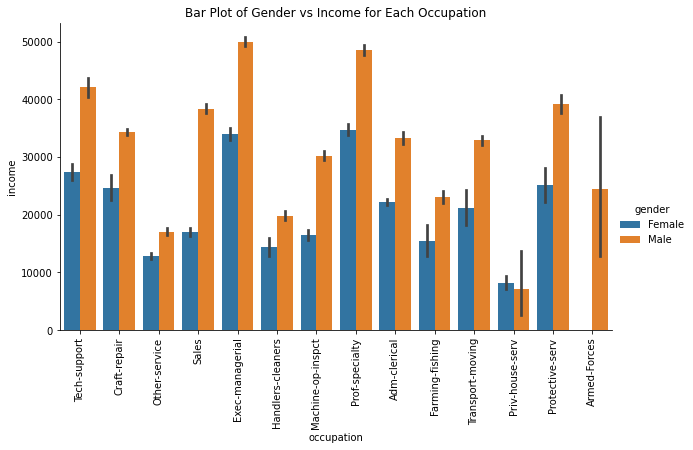

In [29]:
sns.catplot(data=df, kind="bar", x="occupation", y="income", hue="gender", aspect=14/8)
plt.xticks(rotation=90)
plt.title('Bar Plot of Gender vs Income for Each Occupation')

#### Here you can see that generally (not given the same education level), females have less income given the same occupation.

Text(0.5, 1.0, 'Bar Plot of Gender vs Hours-per-week for Each Occupation')

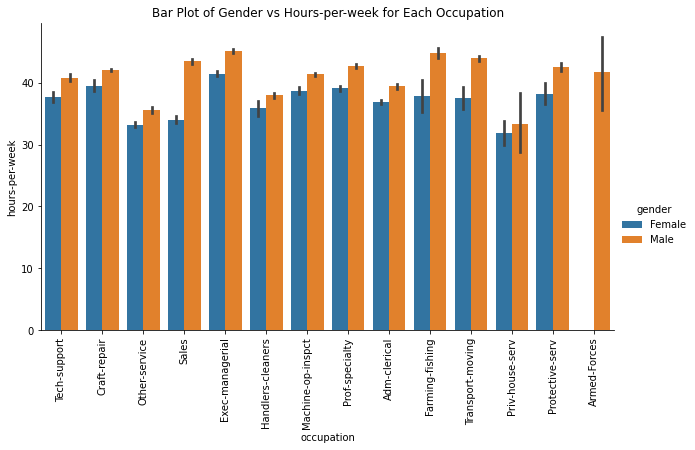

In [30]:
sns.catplot(data=df, kind="bar", x="occupation", y="hours-per-week", hue="gender", aspect=14/8)
plt.xticks(rotation=90)
plt.title('Bar Plot of Gender vs Hours-per-week for Each Occupation')

#### However, given the same occupation, the two sexes do not have much differences in the hours per week. In all cases males work more more the difference is not as high as with the income. (So you could not fully blame that males have more income based on they work more, or are employed in occupations that give higher income. Clearly, given the same occupation and approximately same hours per week, the income of women is still less.)

##### Let's check for which categorical data feature engineering is worth it

In [31]:
def drawPlot(xName):

    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x=xName,
        y='income',
        data=df.sort_values(xName),
        ax=axs[0]
    )

    sns.countplot(
        x=xName,
        data=df.sort_values(xName),
        ax=axs[1]
    )

    # Draw median price
    axs[0].axhline(
        y=df['income'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)
    fig.suptitle('Plot of the Income of the People from each '+xName,fontsize = 16)

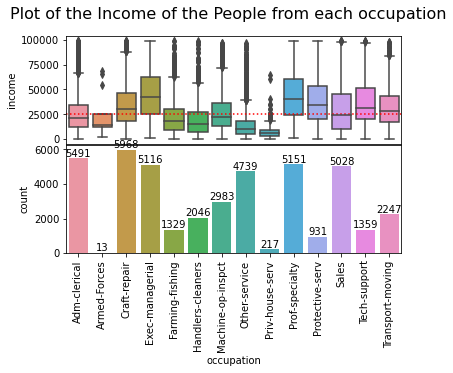

In [32]:
drawPlot("occupation")

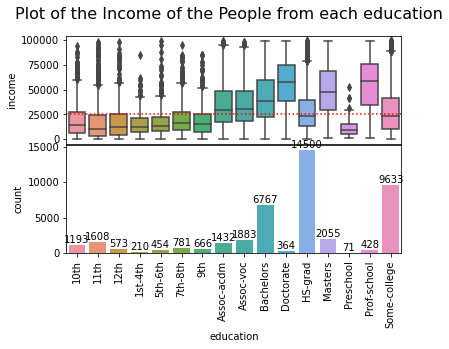

In [33]:
drawPlot("education")

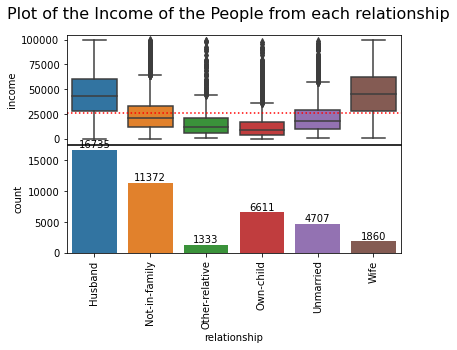

In [34]:
drawPlot("relationship")

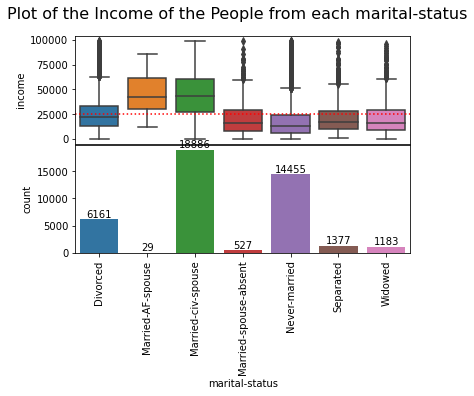

In [35]:
drawPlot("marital-status")

#### For the plots below, you can see that the features are very biased and hence feature engineering on those features would not make sense. We decided to feature engineer the features from above's plots.

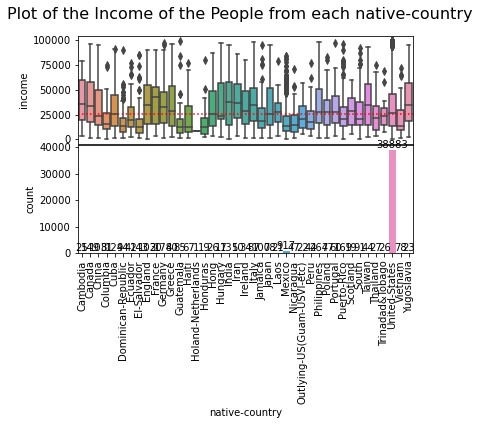

In [36]:
drawPlot("native-country")

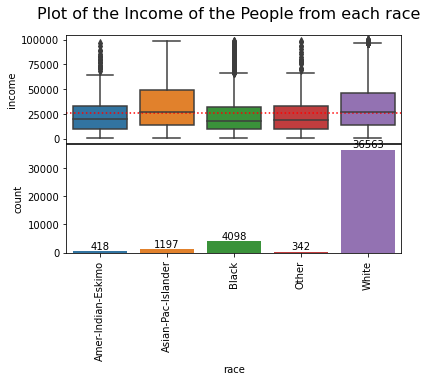

In [37]:
# Very biased, so no feature engineering on this feature as well as not on gender
drawPlot("race")

# 4) Create The Preprocessing Pipeline <a name="prepro"></a>

In [38]:
def select_columns(data, *columns):
    all_columns = []

    for val in data.columns:
        if val.startswith(columns):
            all_columns.append(val)

    return data.reindex(columns = all_columns)

In [39]:
def standardize_columns(data,epsilon=1e-100):
    standardized_data = (data - np.mean(data))/(np.std(data) + epsilon)
    return standardized_data

In [40]:
def rmse(actual, predicted):
    rmse = np.sqrt(np.mean((actual - predicted)**2))
    # Normalized RMSE
    return rmse/(max(actual)-min(actual))

###### Create function for dummy values for all categorical data

In [41]:
def oheCategoricalData(data):
    to_drop = ["workclass", "education", "marital-status", "relationship", "race", "native-country", "occupation", "gender"]
    dummy_vars = pd.get_dummies(data[to_drop])
    data = pd.concat([data.drop(to_drop, axis=1), dummy_vars], axis = 1)
    return data

###### Create functions for feature engineering

In [42]:
def find_highIncome(xName, data, n=3, metric=np.median ):
    return data.groupby(xName).agg(metric).sort_values(by=["income"],ascending=False).iloc[:n].index.values.tolist()

def add_in_highIncome(data, highIncome, xName):
    data["in_rich_"+xName] = 0
    mask = data[xName].isin(highIncome)
    data.loc[mask,"in_rich_"+xName] = 1
    return data, "in_rich_"+xName

In [43]:
def process_data(data):
    # Drop NaNs and duplicates
    data['workclass'] = data['workclass'].replace('?', np.nan)
    data['occupation'] = data['occupation'].replace('?', np.nan)
    data['native-country'] = data['native-country'].replace('?', np.nan)
    data.dropna(how='any', inplace=True)
    data = data.drop_duplicates()
    
    # Feature Engineering
    rich_Occupation = find_highIncome('occupation', data, n=3, metric=np.median )
    data, richOccs = add_in_highIncome(data, rich_Occupation, 'occupation')
    
    rich_Education = find_highIncome('education', data, n=3, metric=np.median )
    data, richEds = add_in_highIncome(data, rich_Education, 'education')

    rich_rel = find_highIncome('relationship', data, n=3, metric=np.median )
    data, richRels = add_in_highIncome(data, rich_rel, 'relationship')

    rich_MS = find_highIncome('marital-status', data, n=1, metric=np.median )
    data, richMS = add_in_highIncome(data, rich_MS, 'marital-status')
    
    # Create dummy variables for categorical    
    data = oheCategoricalData(data)

    data = (
        data
        # Clean Data
        .pipe(remove_outliers_sd, 'hours-per-week') # (681 outliers)
        .pipe(remove_outliers_bound, 'income', upper = 99497 ) 

        # Transform data
        .pipe(select_columns, 
              'age',                                 
              'education-num', 
              'workclass',
              'hours-per-week',
              'income',
              richOccs,
              richEds,
              richMS,

             )
    ) 
    
    # X = standardize_columns(data).drop(['income'], axis = 1)
    X = data.drop(['income'], axis = 1)
    y = data['income']
    
    return X, y

# 5) Analysis Methods <a name="modelling"></a>

First of all, we are going to train a Lasso model on the preprocessed data. Then, we balance the data based on the gender and train it again to see the results.

In [44]:
main_df = pd.read_csv('adult_reconstruction.csv')
X, y = process_data(main_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=5)

/var/folders/yk/j071n21n4hx934n3wqzwtsyh0000gn/T/ipykernel_52013/2539868690.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["in_rich_"+xName] = 0
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


#### Lasso Model

In [45]:
from sklearn import linear_model as lm
alphas = np.arange(0.1, 200.1, .1)
final_model = lm.LassoCV(alphas=alphas,cv=5, max_iter = 10000)
final_model.fit(X_train, y_train)

y_predicted_train = final_model.predict(X_train)
y_predicted_test = final_model.predict(X_test)

train_score = rmse(y_predicted_train, y_train)
test_score = rmse(y_predicted_test, y_test)

print("Normalized RMSE Train: ", train_score, "Normalized RMSE Test: ", test_score)

Normalized RMSE Train:  0.17129834465131408 Normalized RMSE Test:  0.17600750146048014


### 5.1) How does balancing the number of males and females for each occupation affect the distribution of the gender vs income plot?

#### Comparing Plots of Test and Predicted Income Values Based on Gender

In [46]:
test_copy = X_test.copy()
test_copy = pd.concat([X_test, y_test], axis = 1)
test_copy['prediction'] = y_predicted_test

test_copy['gender'] = df[df.index.isin(test_copy.index)]['gender']
test_copy['occupation'] = df[df.index.isin(test_copy.index)]['occupation']

[Text(0.5, 1.0, 'Histogram of Different Actual Incomes')]

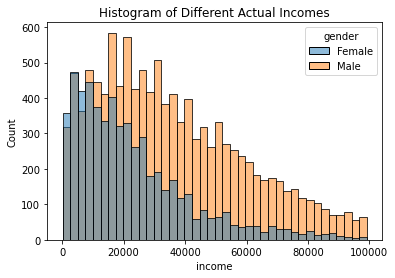

In [47]:
sns.histplot(data=test_copy, x='income', hue="gender").set(title = 'Histogram of Different Actual Incomes')

[Text(0.5, 1.0, 'Histogram of Different Predicted Incomes')]

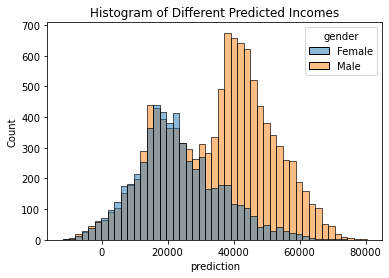

In [48]:
sns.histplot(data=test_copy, x='prediction', hue="gender").set(title='Histogram of Different Predicted Incomes')

The plot above shows how the model is biased even though we did not feed it any inofrmation about the gender of the people. We think this is because the data is unbalanced (there are more males than females). We try to solve this problem by balancing the number of males and females below.

## Create a model using data where the number of males and female for each occupation is equal

### newDATA is the data where the number males and females working in an occupation is made to be equal

In [49]:
#Encode the occupations into numbers for the plot below
dictt = dict()
count = 1
for k in list(set(list(df['occupation']))):
    dictt[k]=count
    count+=1
print(dictt)

newdf = df.copy()
for d in dictt:
    newdf=newdf.replace(d, dictt[d])

listCounts=dict()
newDATA = pd.DataFrame()
for d in dictt:
    
    occupation = dictt[d]
    temp = newdf[newdf['occupation']==occupation]
    
    male = temp[temp['gender']=='Male']
    female = temp[temp['gender']=='Female']
    
    countMale = len(male)
    countFemale = len(female)
    
    listCounts[occupation] = [countMale, countFemale]
    
    #find the minimum then which gender is the min
    minn = min(listCounts[occupation])
    gender = listCounts[occupation].index(minn) ## if 0 then male, if 1 then female
    
    diff = abs(countMale-countFemale)
    
    if gender==0: ## then females need to be removed
        female= female.drop(female.index[len(female)-diff:len(female)], inplace=False)
    else:
        male = male.drop(male.index[len(male)-diff:len(male)], inplace=False)

    newDATA = pd.concat([newDATA, female], axis=0)
    newDATA = pd.concat([newDATA, male], axis=0)

{'Exec-managerial': 1, 'Protective-serv': 2, 'Adm-clerical': 3, 'Transport-moving': 4, 'Tech-support': 5, 'Machine-op-inspct': 6, 'Other-service': 7, 'Prof-specialty': 8, 'Priv-house-serv': 9, 'Sales': 10, 'Armed-Forces': 11, 'Craft-repair': 12, 'Farming-fishing': 13, 'Handlers-cleaners': 14}


In [50]:
main_df = pd.read_csv('adult_reconstruction.csv')
X, y = process_data(newDATA)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=5)

#### Lasso Model

In [51]:
from sklearn import linear_model as lm
alphas = np.arange(0.1, 200.1, .1)
final_model = lm.LassoCV(alphas=alphas,cv=5, max_iter = 10000)
final_model.fit(X_train, y_train)

y_predicted_train = final_model.predict(X_train)
y_predicted_test = final_model.predict(X_test)

train_score = rmse(y_predicted_train, y_train)
test_score = rmse(y_predicted_test, y_test)

print("Normalized RMSE Train: ", train_score, "Normalized RMSE Test: ", test_score)

Normalized RMSE Train:  0.1663046970191129 Normalized RMSE Test:  0.1621305046837287


In [52]:
test_copy = X_test.copy()
test_copy = pd.concat([X_test, y_test], axis = 1)
test_copy['prediction'] = y_predicted_test

test_copy['gender'] = df[df.index.isin(test_copy.index)]['gender']
test_copy['occupation'] = df[df.index.isin(test_copy.index)]['occupation']

### Comparing Plots of Test and Predicted Income Values Based on Gender

[Text(0.5, 1.0, 'Histogram of Different Actual Incomes')]

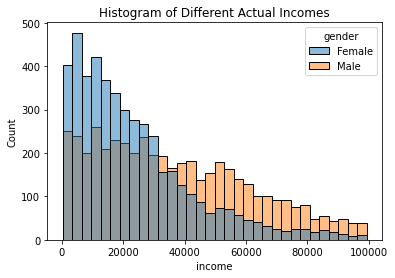

In [53]:
sns.histplot(data=test_copy, x='income', hue="gender").set(title = 'Histogram of Different Actual Incomes')

[Text(0.5, 1.0, 'Histogram of Different Predicted Incomes')]

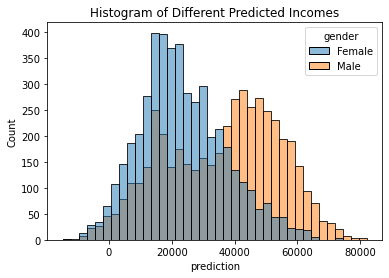

In [54]:
sns.histplot(data=test_copy, x='prediction', hue="gender").set(title='Histogram of Different Predicted Incomes')

Here we can see that the model has somewhat improved after the data got balanced.

# Ethical Considerations <a name="ethics"></a>

There are various ethical concerns that can be discussed with this dataset and also the analysis that was done throughout this project. Firstly, the data that was used contains many sensitive information like age, gender, marital-status, and race. When the data was plotted based on these features, it was clear that there was no balance in the dataset. The categorical variables had limited options, especially for race. It is well known that people from many ethnicities live in the US, and this diversity was not present in the dataset. And, the fact that there was no balance in each category gives rise to more bias in the analysis. More data is collected from white males; therefore, minorities are not represented well enough both in the dataset and the analysis as well. 

Another ethical issue that can be raised is the privacy of the citizens who have provided this information. It is unknown whether they were aware of the fact that their personal information was to be used for data analysis, or even predictions of income based on profiles. Companies could use this data to automatically generate the salary range that they can give to certain groups of people if they are following a biased recruitment policy, which gives rise to more discrimination among the citizens. 

Most importantly, the need to collect sensitive information of citizens to do data analysis and predictions proves that people think this information has an impact on the financial status of someone. However, it is important to show others that discrimination exists in many ways but this type of dataset should not be used for any type of decision making for the future in the sense that it will determine someone’s financial situation. 
